# Get Image Labels

In [144]:
import scipy
import scipy.io as sio
from scipy.io import loadmat
import numpy as np 
import pandas as pd
from collections import Counter
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [2]:
# @title Load mat files
def loadmat(matfile):
  """Function to load .mat files.
  Parameters
  ----------
  matfile : str
      path to `matfile` containing fMRI data for a given trial.
  Returns
  -------
  dict
      dictionary containing data in key 'vol' for a given trial.
  """
  try:
    f = h5py.File(matfile)
  except (IOError, OSError):
    return sio.loadmat(matfile)
  else:
    return {name: np.transpose(f.get(name)) for name in f.keys()}

Link to download visual_stimuli.mat: http://wednesday.csail.mit.edu/MEG1_MEG_Clear_Data/visual_stimuli.mat

In [3]:
# crediting Lindsey
def get_stim_details(path_to_file):
  """
  acquire category names and binary features describing the Cichy images

  returns: stim_details (dict containing 5 keys: category (str), and four binary features (animate, human, natural, face)). 
                          each key holds an array giving the information for all categories
  """
  stim_dat = loadmat(path_to_file)['visual_stimuli']
  fields = ['category', 'animate', 'human', 'natural', 'face']
  stim_details = {field:[] for field in fields}
  for ii in range(92):
    for jj, field in enumerate(fields):
      stim_details[field].append(stim_dat[0,ii][jj][0])
  for field in fields[1:]:
    stim_details[field] = np.array(stim_details[field]).squeeze()
  return stim_details


# Create a dictionary with image categories and corresponding image numbers

In [49]:
def sorting_images(dict, key, value):
    '''
    Sorting images based on their categories, if the category doesn't exist then create a key in the dict then append the image number. 
    '''
    if key not in dict:
        print(f'adding a new key: {key}')
        dict[key] = []
    dict[key].append(value)

def segment_image_categories(dict, category):
    '''
    return the image number in the specific category (string)
    '''
    if category not in dict:
        return f'No images found for category: {category}'
    else:
        return(dict[category])

In [86]:
# load the category of the images
stim_dat = loadmat('/Users/momoqyan1/Documents/NMA/data/92_Image_Set/visual_stimuli.mat')

label_dict = {} # create an empty dictionary where categories of images and corresponding image names are saved

# create a dictionary with categories(key): names of images(values)
for i in range(92):
    label = stim_dat['visual_stimuli'][0][i][0][0]
    name = i
    sorting_images(label_dict, label, name)

print(f'The number of keys in the dictionary is: {len(label_dict)}')

adding a new key: human bodypart
adding a new key: human face
adding a new key: nonhuman bodypart
adding a new key: nonhuman face
adding a new key: natural inanimate
adding a new key: artificial inanimate
The number of keys in the dictionary is: 6


# Segment MEG RDMs based on speficied categories

In [104]:
def binning_rdm_timepoints(rdm, stepsize):
    '''
    bin MEG RDMs in specified time step
    @param: MEG RDMs across all timepoints; size of the time step
    return an ndarray with binning MEG RDMs
    '''
    rdm_in_bins = []
    timepoints = np.arange(-100, 1200, stepsize)

    for timepoint in timepoints:
        #Load RDM at a given timepoint
        # +100 as the RDMs provided are from -100ms to 1000ms after the stimulus onset
        bin = np.array(rdm[timepoint+100])
        rdm_in_bins.append(bin)
    
    return rdm_in_bins

In [142]:
def segmenting_rdm_categories(rdm, category):
    '''
    @param: original RDM to segment the categories from (should be size (92, 92)); category that we want to segment (should be one of the variables saved before)
    returns a new RDM between images in the specified category
    '''
    start_idx = category[0]
    end_idx = category[-1]
    segmented_rdm = rdm[start_idx:end_idx+1, start_idx:end_idx+1]
    return segmented_rdm

def pooling_rdm_category(rdm, category_name):
    '''
    use the helper functions above and return an ndarray of MEG RDM with images from specified category
    '''
    category = segment_image_categories(label_dict, category_name)
    category_rdm = segmenting_rdm_categories(rdm, category)
    return category_rdm

def visualizing_rdm_category(rdm, category_name, rdmtype):
    '''
    visualize MEG RDM with simuli from the same category
    '''
    category = segment_image_categories(label_dict, category_name)
    category_rdm = segmenting_rdm_categories(rdm, category)
    plt.imshow(category_rdm, cmap="bwr")
    plt.title(f"{rdmtype} RDM for {category_name}")
    cbar = plt.colorbar()
    plt.xlabel("Stimuli")
    plt.ylabel("Stimuli")
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Decoding Accuracy', rotation=270)
    plt.show()

In [126]:
# Load MEG RDMs for each time point for all subjects all sessions
MEG_RDMs = loadmat("/Users/momoqyan1/Documents/NMA/data/MEG_decoding_RDMs.mat")['MEG_decoding_RDMs']
print(MEG_RDMs.shape)

(16, 2, 1301, 92, 92)


Pre-process MEG RDMs based on however you want to average them

In [133]:
# Average MEG RDMs among 2 sessions
MEG_RDM_sess_averaged = np.mean(MEG_RDMs, axis=(1))
print(MEG_RDM_sess_averaged.shape)

# Average MEG RDMs among 15 subjects
MEG_RDM_sub_averaged = np.mean(MEG_RDMs, axis=(0))
print(MEG_RDM_sub_averaged.shape)

# Average MEG RDMs among 15 subjects and 2 sessions
MEG_RDM_all_averaged = np.mean(MEG_RDMs, axis=(0, 1))
print(MEG_RDM_all_averaged.shape)

# Average MEG RDMs among 1300ms and subjects and sessions
MEG_RDM_time_all_averaged = np.mean(MEG_RDMs, axis=(0, 1, 2))
print(MEG_RDM_time_all_averaged.shape)

(16, 1301, 92, 92)
(2, 1301, 92, 92)
(1301, 92, 92)
(92, 92)


You can also bin MEG RDMs with certain time window if you don't want to work with 1300 MEG RDMS (since there will be one for each ms)

In [128]:
binned_rdms = binning_rdm_timepoints(MEG_RDM_all_averaged, 20) # bin MEG RDMs in 20ms time steps 

65


You can save MEG RDMs for stimuli in the specified category like this:  
    category_MEG_RDM = pooling_rdm_category(MEG_RDM, category);
Please assign the correct MEG RDM and category you want to work with.

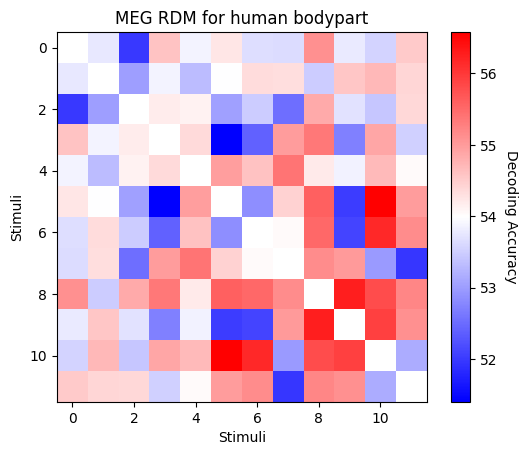

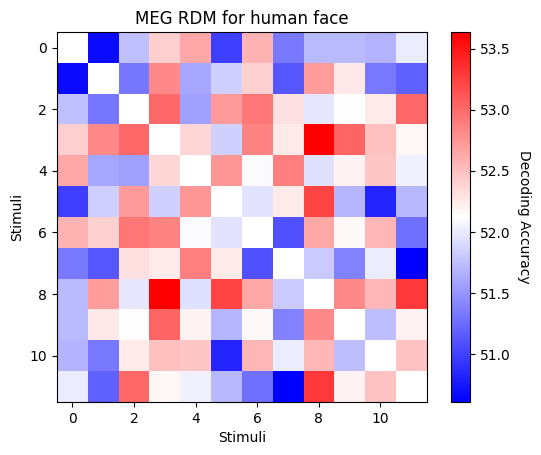

In [136]:
# visualize MEG RDM with stimuli from the specified category
visualizing_rdm_category(MEG_RDM_time_all_averaged,'human bodypart')
visualizing_rdm_category(MEG_RDM_time_all_averaged,'human face')

# Segment fMRI RDMs based on speficied categories

In [137]:
fMRI_file = '/Users/momoqyan1/Documents/NMA/data/92_Image_Set/target_fmri.mat'  # path of fMRI RDM file
fMRI_RDMs = loadmat(fMRI_file)  # load the fMRI RDMs
print(fMRI_RDMs.keys())
fMRI_RDM_EVC = fMRI_RDMs['EVC_RDMs']
fMRI_RDM_IT = fMRI_RDMs['IT_RDMs']
print(fMRI_RDM_EVC.shape)
print(fMRI_RDM_IT.shape)

dict_keys(['EVC_RDMs', 'IT_RDMs'])
(15, 92, 92)
(15, 92, 92)


Pre-process fMRI RDMs based on however you want to average them

In [138]:
# Average fMRI RDMs across subjects
RDM_EVC = np.array(fMRI_RDM_EVC.mean(axis=0)) 
RDM_IT = np.array(fMRI_RDM_IT.mean(axis=0))

You can save fMRI RDMs for stimuli in the specified category like this:  
    category_fMRI_RDM = pooling_rdm_category(fMRI_RDM_brain_region, category); 
Please assign the correct MEG RDM and category you want to work with.

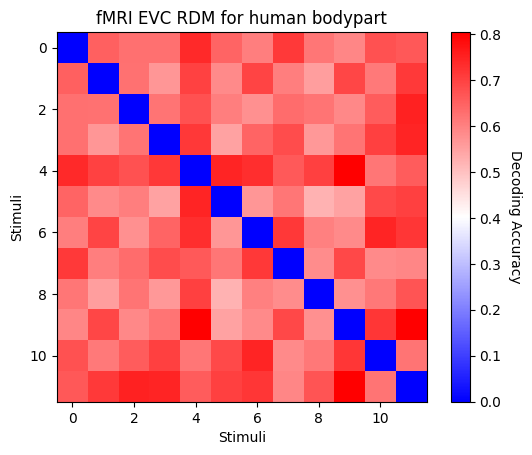

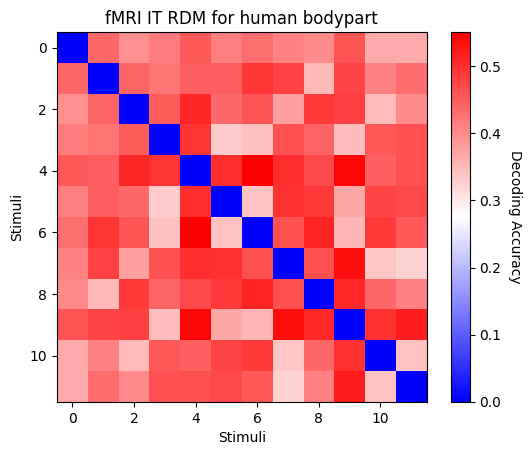

In [143]:
# visualize fMRI RDM from different brain regions with stimuli from the specified category
visualizing_rdm_category(RDM_EVC,'human bodypart', 'fMRI EVC')
visualizing_rdm_category(RDM_IT,'human bodypart', 'fMRI IT')

# Comparison of fMRI and MEG RDMs for different categories

In [145]:
# RDM comparison functions
def RSA_spearman(rdm1,rdm2):
  """
  computes and returns the spearman correlation between lower triangular
  part of the input rdms. We only need to compare either lower or upper
  triangular part of the matrix as RDM is symmetric
  """
  # get lower triangular part of the RDM1
  lt_rdm1 = get_lowertriangular(rdm1)
  # get lower triangular part of the RDM1
  lt_rdm2 = get_lowertriangular(rdm2)
  # return Spearman's correlation between lower triangular part of rdm1 & rdm2
  return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
  """
  returns lower triangular part of the matrix
  """
  num_conditions = rdm.shape[0]
  return rdm[np.tril_indices(num_conditions, -1)]